In [1]:
%cd /home/stefano/dev/active/spreads-arb
%load_ext line_profiler

import itertools
import logging
import os
import pickle
from datetime import date, datetime, timedelta

import cryptomart as cm
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import pyutil
import requests
import vectorbt as vbt

import argparse
import os
import pickle

import cryptomart as cm
import pandas as pd
from app.data_prep.dummy import dummy_bid_ask_spreads
from app.data_prep.real import all_bid_ask_spreads, all_funding_rates, all_ohlcv, get_fee_info
from app.feeds import Spread

import app

identifier = "spreads-arb-v2"

# spreads = pd.read_pickle("/home/stefano/dev/active/spreads-arb/data/granular_spreads.pkl")
# spread = pickle.loads(spreads.iloc[0].spread)
# res = app.BacktestRunner(
#     log_dir=os.path.join(
#         os.getenv("ACTIVE_DEV_PATH", "/home/stefano/development/active_dev"), "logs", "spreads-arb-v2"
#     ),
#     vbt_function=app.vbt.chained_quotes,
#     use_slippage=False,
#     use_funding_rate=False,
#     profitable_only=True,
#     z_score_thresholds=(0, 1),
#     z_score_period=30,
# ).run_quotes(spreads)

/home/stefano/dev/active/spreads-arb


In [16]:
spread.zscore(column="mid_price", period=30).head(200)

timestamp
2023-03-12 00:00:00         NaN
2023-03-13 00:00:00         NaN
2023-03-14 00:00:00         NaN
2023-03-15 00:00:00         NaN
2023-03-16 00:00:00         NaN
                         ...   
2023-04-10 00:13:50   -1.110644
2023-04-10 00:13:55   -1.043289
2023-04-10 00:14:00   -0.805692
2023-04-10 00:14:05   -0.682472
2023-04-10 00:14:10   -0.857684
Name: zscore, Length: 200, dtype: float64

In [6]:

leg_0_bid = np.array(
    spreads.apply(lambda s: pickle.loads(s.spread).underlying_col("bid_price").T.iloc[0], axis=1)
)
leg_1_bid = np.array(
    spreads.apply(lambda s: pickle.loads(s.spread).underlying_col("bid_price").T.iloc[1], axis=1)
)
bid_prices = np.concatenate([leg_0_bid, leg_1_bid], axis=0).T
bid_prices = np.vstack((np.full_like(bid_prices[:29], np.nan), bid_prices))
        
leg_0_ask = np.array(
    spreads.apply(lambda s: pickle.loads(s.spread).underlying_col("ask_price").T.iloc[0], axis=1)
)
leg_1_ask = np.array(
    spreads.apply(lambda s: pickle.loads(s.spread).underlying_col("ask_price").T.iloc[1], axis=1)
)
ask_prices = np.concatenate([leg_0_ask, leg_1_ask], axis=0).T
ask_prices = np.vstack((np.full_like(ask_prices[:29], np.nan), ask_prices))
        
leg_0_bid_sz = np.array(
    spreads.apply(lambda s: pickle.loads(s.spread).underlying_col("bid_amount").T.iloc[0], axis=1)
)
leg_1_bid_sz = np.array(
    spreads.apply(lambda s: pickle.loads(s.spread).underlying_col("bid_amount").T.iloc[1], axis=1)
)
bid_sizes = np.concatenate([leg_0_bid_sz, leg_1_bid_sz], axis=0).T
bid_sizes = np.vstack((np.full_like(bid_sizes[:29], np.nan), bid_sizes))
        
leg_0_ask_sz = np.array(
    spreads.apply(lambda s: pickle.loads(s.spread).underlying_col("ask_amount").T.iloc[0], axis=1)
)
leg_1_ask_sz = np.array(
    spreads.apply(lambda s: pickle.loads(s.spread).underlying_col("ask_amount").T.iloc[1], axis=1)
)
ask_sizes = np.concatenate([leg_0_ask_sz, leg_1_ask_sz], axis=0).T
ask_sizes = np.vstack((np.full_like(ask_sizes[:29], np.nan), ask_sizes))


leg_0_mid = np.array(
    spreads.apply(lambda s: pickle.loads(s.spread).underlying_col("mid_price").T.iloc[0], axis=1)
)
leg_1_mid = np.array(
    spreads.apply(lambda s: pickle.loads(s.spread).underlying_col("mid_price").T.iloc[1], axis=1)
)
mid_prices = np.concatenate([leg_0_mid, leg_1_mid], axis=0).T
mid_prices = np.vstack((np.full_like(mid_prices[:29], np.nan), mid_prices))

zscore = np.array(
    spreads.apply(lambda s: pickle.loads(s.spread).zscore("bid_price", 30), axis=1)
).T

In [44]:
bid_prices.nbytes / 1024 / 1024

791.0598754882812

In [7]:
bid_prices.shape

(518429, 200)

In [11]:
current_zscore = zscore[593]

In [14]:
direction = np.where(np.abs(current_zscore) > 1, -np.sign(current_zscore), 0)

In [15]:
direction

array([ 0.,  0., -1.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
       -1.,  0.,  0., -1.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  1.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,
        1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0., -1., -1.,  0.,  0.,
        0.,  0.,  1.,  0.,  1.,  0., -1.,  1.,  0.,  0.,  0.,  0., -1.,
        0.,  0.,  0., -1.,  0.,  0.,  1.,  0.,  0.])

In [16]:
ask_price = ask_prices[593]
ask_size = ask_sizes[593]
bid_price = bid_prices[593]
bid_size = bid_sizes[593]

In [23]:
leg_0_sizes = np.where(direction == 1, bid_size[:100], ask_size[:100])
leg_1_sizes = np.where(direction == 1, bid_size[100:], ask_size[100:])

In [30]:
leg_0_sizes

array([3.61857143e+03, 4.50915333e+04, 8.44090909e+01, 1.61380714e+04,
       1.61380714e+04, 7.66769048e+01, 1.10951250e+04, 9.96811765e+02,
       6.51228571e+04, 2.14062500e+01, 3.05825000e+03, 2.76796667e+04,
       2.76796667e+04, 3.67827760e+04, 1.07333333e+01, 6.80857143e+01,
       8.25238409e+06, 5.77575571e+03, 2.67000000e+05, 2.67000000e+05,
       2.67000000e+05, 4.00000000e+05, 4.00000000e+05, 4.00000000e+05,
       3.30000000e+04, 3.30000000e+04, 3.30000000e+04, 3.20000000e+04,
       3.20000000e+04, 3.20000000e+04, 5.30000000e+04, 5.30000000e+04,
       5.30000000e+04, 6.83000000e+05, 6.83000000e+05, 1.16545000e+03,
       7.38181818e+04, 1.58712500e+03, 2.05668333e+04, 2.48808600e+04,
       7.78649250e+04, 6.43000000e+01, 6.43000000e+01, 3.71500000e+02,
       1.10803333e+03, 1.22523333e+02, 2.60400000e+03, 4.52753000e+04,
       1.21655400e+06, 1.98792353e+04, 3.60000000e+01, 2.12920000e+04,
       2.12920000e+04, 3.13000000e+02, 3.13000000e+02, 9.46997143e+03,
      

In [33]:
sizes = np.vstack((leg_0_sizes, leg_1_sizes)).T
sizes.shape

(100, 2)

In [25]:
leg_1_sizes.shape

(100,)

In [18]:
ask_price.shape

(200,)

In [37]:
from numba import njit



@njit
def foo(x, y):
    if x is not None:
        print(1)

foo(None, 2)

In [2]:
leg_0_bid = np.array(
    spreads.apply(lambda s: pickle.loads(s.spread).underlying_col("bid_price").T.iloc[0], axis=1)
)
leg_1_bid = np.array(
    spreads.apply(lambda s: pickle.loads(s.spread).underlying_col("bid_price").T.iloc[1], axis=1)
)
bid_prices = np.concatenate([leg_0_bid, leg_1_bid], axis=0).T
    

In [3]:
bid_prices.shape

(518400, 200)

In [7]:
np.full_like(bid_prices[:29], np.nan).shape

(29, 200)

In [14]:
np.vstack((np.full_like(bid_prices[:29], np.nan), bid_prices))

array([[           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       ...,
       [1.03130000e-01, 1.26300000e-01, 1.53050000e+01, ...,
        1.57666667e-02, 3.82700000e+01, 9.05000000e-01],
       [1.03130000e-01, 1.26300000e-01, 1.53050000e+01, ...,
                   nan, 3.82700000e+01, 9.05000000e-01],
       [1.03120000e-01,            nan, 1.53050000e+01, ...,
                   nan, 3.82700000e+01, 9.05000000e-01]])

In [5]:
np.insert(bid_prices, 0, np.full_like(bid_prices[:29], np.nan))

ValueError: could not broadcast input array from shape (29,200) into shape (29,)

In [2]:
logging.getLogger("pyutil.cache").setLevel("WARNING")

quotes = app.data_prep.all_tardis_quotes()
quotes

quotes
exchange inst_type symbol                                                   
okex     perpetual GFT     b'\x80\x04\x95\r\x01\x00\x00\x00\x00\x00\x00\x...
                   ICP     b'\x80\x04\x95\r\x01\x00\x00\x00\x00\x00\x00\x...
                   FIL     b'\x80\x04\x95\r\x01\x00\x00\x00\x00\x00\x00\x...
                   CEL     b'\x80\x04\x95\r\x01\x00\x00\x00\x00\x00\x00\x...
                   ETHW    b'\x80\x04\x95\r\x01\x00\x00\x00\x00\x00\x00\x...
...                                                                      ...
bitmex   perpetual GMT     b'\x80\x04\x95\r\x01\x00\x00\x00\x00\x00\x00\x...
                   BNB     b'\x80\x04\x95\r\x01\x00\x00\x00\x00\x00\x00\x...
                   ADA     b'\x80\x04\x95\r\x01\x00\x00\x00\x00\x00\x00\x...
                   APE     b'\x80\x04\x95\r\x01\x00\x00\x00\x00\x00\x00\x...
                   ETH     b'\x80\x04\x95\r\x01\x00\x00\x00\x00\x00\x00\x...

[703 rows x 1 columns]

In [3]:

for idx, row in quotes.iterrows():
    exchange, inst_type, symbol = idx
    daily_close = app.data_prep.real.cm_client.ohlcv(exchange, symbol, inst_type, "2023-03-12", "2023-04-10")
    if daily_close.close.isna().any():
        quotes.drop(idx, inplace=True)
        continue
        
    q = pickle.loads(row.quotes).set_index("timestamp")
    q = q.iloc[:9000]
    if q.mid_price.isna().any():
        quotes.drop(idx, inplace=True)
        continue
    
    combined_prices = pd.concat([q.mid_price, daily_close.set_index("open_time").close], axis=0).sort_index()
    q = q.reindex(combined_prices.index)
    q["mid_price"] = combined_prices
    q.index.name = "timestamp"
    q = q.reset_index()
    quotes.at[idx, "quotes"] = pickle.dumps(q)
        

<AxesSubplot:xlabel='timestamp'>

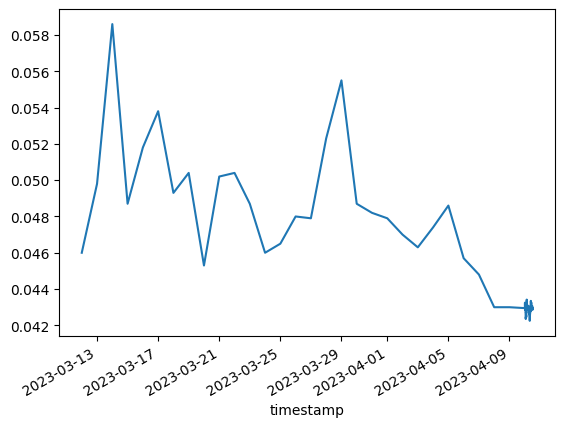

In [57]:
pickle.loads(quotes.iloc[0].quotes).set_index("timestamp").mid_price.plot()

<AxesSubplot:xlabel='timestamp'>

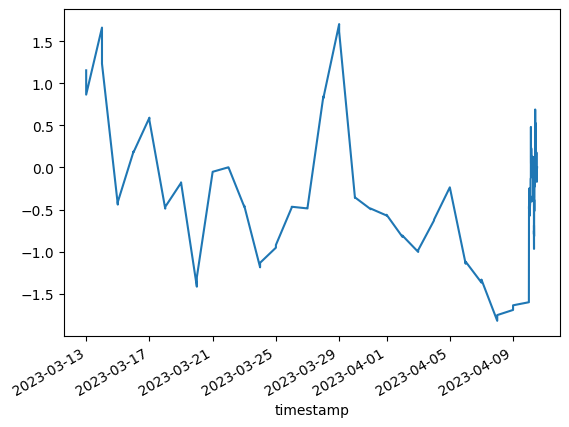

In [59]:
pickle.loads(quotes.iloc[0].quotes).zscore().plot()

In [5]:
pickle.loads(quotes.iloc[0].quotes)

,timestamp,ask_amount,ask_price,bid_price,bid_amount,mid_price
0,2023-04-10 00:00:00,170.0,0.0430,0.0429,1328.333333,0.04295
1,2023-04-10 00:00:05,80.0,0.0430,0.0429,1472.600000,0.04295
2,2023-04-10 00:00:10,170.0,0.0430,0.0429,1583.000000,0.04295
3,2023-04-10 00:00:15,20.0,0.0430,0.0429,1583.000000,0.04295
4,2023-04-10 00:00:20,120.0,0.0430,0.0429,1583.000000,0.04295
...,...,...,...,...,...,...
518395,2023-05-09 23:59:35,216.0,0.0258,0.0257,1127.000000,0.02575
518396,2023-05-09 23:59:40,216.0,0.0258,0.0257,1127.000000,0.02575
518397,2023-05-09 23:59:45,NaN,NaN,NaN,NaN,NaN
518398,2023-05-09 23:59:50,NaN,NaN,NaN,NaN,NaN


In [4]:
fee_info = app.data_prep.get_fee_info(refresh=False, identifiers=[identifier])
fee_info

maint_margin  init_margin  fee_pct  fee_fixed
exchange symbol                                               
binance  BTC            0.025        0.050   0.0004        0.0
         ETH            0.025        0.050   0.0004        0.0
         BCH            0.025        0.050   0.0004        0.0
         XRP            0.025        0.050   0.0004        0.0
         EOS            0.025        0.050   0.0004        0.0
...                       ...          ...      ...        ...
okex     YGG            0.010        0.025   0.0005        0.0
         ZEC            0.015        0.020   0.0005        0.0
         ZEN            0.015        0.020   0.0005        0.0
         ZIL            0.015        0.020   0.0005        0.0
         ZRX            0.015        0.020   0.0005        0.0

[1002 rows x 4 columns]

In [5]:
instrument_data = quotes.join(fee_info).reorder_levels(quotes.index.names)
instrument_data

quotes  \
exchange inst_type symbol                                                        
binance  perpetual 1000LUNC  b'\x80\x04\x95\x0b\x01\x00\x00\x00\x00\x00\x00...   
                   1000XEC   b'\x80\x04\x95\x0b\x01\x00\x00\x00\x00\x00\x00...   
                   1INCH     b'\x80\x04\x95\x0b\x01\x00\x00\x00\x00\x00\x00...   
                   AAVE      b'\x80\x04\x95\x0b\x01\x00\x00\x00\x00\x00\x00...   
                   ACH       b'\x80\x04\x95\x0b\x01\x00\x00\x00\x00\x00\x00...   
...                                                                        ...   
okex     perpetual YGG       b'\x80\x04\x95\x0b\x01\x00\x00\x00\x00\x00\x00...   
                   ZEC       b'\x80\x04\x95\x0b\x01\x00\x00\x00\x00\x00\x00...   
                   ZEN       b'\x80\x04\x95\x0b\x01\x00\x00\x00\x00\x00\x00...   
                   ZIL       b'\x80\x04\x95\x0b\x01\x00\x00\x00\x00\x00\x00...   
                   ZRX       b'\x80\x04\x95\x0b\x01\x00\x00\x00\x00\x00\x00...   

                             maint_margin  init_margin  fee_pct  fee_fixed  
exchange inst_type symbol                                                   
binance  perpetual 1000LUNC         0.025        0.050   0.0004        0.0  
                   1000XEC          0.025        0.050   0.0004        0.0  
                   1INCH            0.025        0.050   0.0004        0.0  
                   AAVE             0.025        0.050   0.0004        0.0  
                   ACH              0.025        0.050   0.0004        0.0  
...                                   ...          ...      ...        ...  
okex     perpetual YGG              0.010        0.025   0.0005        0.0  
                   ZEC              0.015        0.020   0.0005        0.0  
                   ZEN              0.015        0.020   0.0005        0.0  
                   ZIL              0.015        0.020   0.0005        0.0  
                   ZRX              0.015        0.020   0.0005        0.0  

[673 rows x 5 columns]

In [6]:
instrument_data_crossed = (
    instrument_data.reset_index()
    .merge(instrument_data.reset_index(), how="cross", suffixes=("_a", "_b"))
    .pipe(
        lambda df: df[
            (df.exchange_a < df.exchange_b) & (df.inst_type_a <= df.inst_type_b) & (df.symbol_a == df.symbol_b)
        ]
    )
    .drop(columns="symbol_b")
    .rename(columns={"symbol_a": "symbol"})
    .reset_index(drop=True)
)
del instrument_data
instrument_data_crossed


,exchange_a,inst_type_a,symbol,quotes_a,maint_margin_a,init_margin_a,fee_pct_a,fee_fixed_a,exchange_b,inst_type_b,quotes_b,maint_margin_b,init_margin_b,fee_pct_b,fee_fixed_b
0,binance,perpetual,1000LUNC,b'\x80\x04\x95\x0b\x01\x00\x00\x00\x00\x00\x00...,0.025,0.050000,0.00040,0.0,bybit,perpetual,b'\x80\x04\x95\x0b\x01\x00\x00\x00\x00\x00\x00...,0.020,0.040,0.00060,0.0
1,binance,perpetual,1000XEC,b'\x80\x04\x95\x0b\x01\x00\x00\x00\x00\x00\x00...,0.025,0.050000,0.00040,0.0,bybit,perpetual,b'\x80\x04\x95\x0b\x01\x00\x00\x00\x00\x00\x00...,0.040,0.080,0.00060,0.0
2,binance,perpetual,1INCH,b'\x80\x04\x95\x0b\x01\x00\x00\x00\x00\x00\x00...,0.025,0.050000,0.00040,0.0,bybit,perpetual,b'\x80\x04\x95\x0b\x01\x00\x00\x00\x00\x00\x00...,0.020,0.040,0.00060,0.0
3,binance,perpetual,1INCH,b'\x80\x04\x95\x0b\x01\x00\x00\x00\x00\x00\x00...,0.025,0.050000,0.00040,0.0,gateio,perpetual,b'\x80\x04\x95\x0b\x01\x00\x00\x00\x00\x00\x00...,0.025,0.040,0.00075,0.0
4,binance,perpetual,1INCH,b'\x80\x04\x95\x0b\x01\x00\x00\x00\x00\x00\x00...,0.025,0.050000,0.00040,0.0,okex,perpetual,b'\x80\x04\x95\x0b\x01\x00\x00\x00\x00\x00\x00...,0.015,0.020,0.00050,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
836,gateio,perpetual,YGG,b'\x80\x04\x95\x0b\x01\x00\x00\x00\x00\x00\x00...,0.025,0.038333,0.00075,0.0,okex,perpetual,b'\x80\x04\x95\x0b\x01\x00\x00\x00\x00\x00\x00...,0.010,0.025,0.00050,0.0
837,gateio,perpetual,ZEC,b'\x80\x04\x95\x0b\x01\x00\x00\x00\x00\x00\x00...,0.025,0.040000,0.00075,0.0,okex,perpetual,b'\x80\x04\x95\x0b\x01\x00\x00\x00\x00\x00\x00...,0.015,0.020,0.00050,0.0
838,gateio,perpetual,ZEN,b'\x80\x04\x95\x0b\x01\x00\x00\x00\x00\x00\x00...,0.025,0.036667,0.00075,0.0,okex,perpetual,b'\x80\x04\x95\x0b\x01\x00\x00\x00\x00\x00\x00...,0.015,0.020,0.00050,0.0
839,gateio,perpetual,ZIL,b'\x80\x04\x95\x0b\x01\x00\x00\x00\x00\x00\x00...,0.025,0.032500,0.00075,0.0,okex,perpetual,b'\x80\x04\x95\x0b\x01\x00\x00\x00\x00\x00\x00...,0.015,0.020,0.00050,0.0


In [6]:
s2 = Spread.from_api("1000LUNC", ["binance", "bybit"], "2023-04-10", "2023-05-10")

2023-05-19 11:41:05.044 INFO     pyutil.cache                                                                      log:89   Using cached value in call to ohlcv((id:binance_ohlcv_perpetual), endtime=2023-05-10, interval=interval_1d, starttime=2023-04-10, strict=False, symbol=1000LUNC) | key=fcc5c6d0794abae3b248624c8a3f1eeb ...
2023-05-19 11:41:05.054 INFO     pyutil.cache                                                                      log:89   Using cached value in call to ohlcv((id:bybit_ohlcv_perpetual), endtime=2023-05-10, interval=interval_1d, starttime=2023-04-10, strict=False, symbol=1000LUNC) | key=0f16ac3a7e6ddbb72b49997efd5dd951 (/...


In [7]:
s = Spread.from_quotes(pickle.loads(instrument_data_crossed.iloc[0].quotes_a), pickle.loads(instrument_data_crossed.iloc[0].quotes_b))

In [7]:

@pyutil.cache.cached("/tmp/cache/spread_volatility", refresh=False)
def load_volatility():
    volatility = pd.DataFrame(
        index=pd.MultiIndex.from_arrays(
            [[], [], [], [], []], names=["exchange_a", "exchange_b", "inst_type_a", "inst_type_b", "symbol"]
        )
    )
    
    for idx, row in instrument_data_crossed.iterrows():
        indexer = (row.exchange_a, row.exchange_b, row.inst_type_a, row.inst_type_b, row.symbol)
        volatility.at[indexer, "volatility"] = Spread.from_quotes(pickle.loads(row.quotes_a), pickle.loads(row.quotes_b)).volatility(column="bid_price")
        
    return volatility

volatility = load_volatility()
volatility.sort_values("volatility", ascending=False).head(20)

volatility
exchange_a exchange_b inst_type_a inst_type_b symbol            
bitmex     bybit      perpetual   perpetual   BLUR    233.863077
           gateio     perpetual   perpetual   BLUR    233.856208
           okex       perpetual   perpetual   BLUR    233.648243
           gateio     perpetual   perpetual   GMX     100.592742
binance    bitmex     perpetual   perpetual   GMX     100.489423
bitmex     okex       perpetual   perpetual   GMX     100.462219
           bybit      perpetual   perpetual   GMX     100.386545
bybit      okex       perpetual   perpetual   FITFI    14.235130
gateio     okex       perpetual   perpetual   BNT      13.630910
                                              FITFI    13.184992
bitmex     okex       perpetual   perpetual   AVAX     10.673721
binance    bitmex     perpetual   perpetual   AVAX     10.626173
bitmex     bybit      perpetual   perpetual   AVAX     10.613176
           gateio     perpetual   perpetual   AVAX     10.592298
gateio     okex       perpetual   perpetual   CVC       9.882961
bybit      gateio     perpetual   perpetual   CVC       9.599278
                                              SXP       8.869801
                                              FITFI     8.668474
binance    gateio     perpetual   perpetual   SXP       8.626633
bybit      gateio     perpetual   perpetual   JST       7.951069

In [8]:
most_volatile = volatility.sort_values("volatility", ascending=False).head(10)

# filtered_idx = (
#     most_volatile.reset_index()
#     .melt(id_vars=["symbol"], value_vars=["exchange_a", "exchange_b"])
#     .drop_duplicates()
#     .assign(inst_type="perpetual")
#     .rename(columns={"value": "exchange"})[["exchange", "inst_type", "symbol"]]
#     .values.tolist()
# )

# quotes_filtered = quotes.loc[filtered_idx]
# del quotes
# quotes_filtered

In [9]:
instrument_data_crossed = instrument_data_crossed.merge(most_volatile, right_index=True, left_on=["exchange_a", "exchange_b", "inst_type_a", "inst_type_b", "symbol"])

In [13]:
instrument_data_crossed.to_pickle("/home/stefano/dev/active/spreads-arb/data/instrument_data_crossed.pkl")

In [13]:
instrument_data_crossed = pd.read_pickle("/home/stefano/dev/active/spreads-arb/data/instrument_data_crossed.pkl")

In [10]:
spreads = pd.DataFrame(
    index=pd.MultiIndex.from_arrays(
        [[], [], [], [], []], names=["exchange_a", "exchange_b", "inst_type_a", "inst_type_b", "symbol"]
    )
)

for idx, row in instrument_data_crossed.iterrows():
    indexer_a = (row.exchange_a, row.inst_type_a, row.symbol)
    indexer_b = (row.exchange_b, row.inst_type_b, row.symbol)
    indexer = (row.exchange_a, row.exchange_b, row.inst_type_a, row.inst_type_b, row.symbol)
    spread = Spread.from_quotes(pickle.loads(row.quotes_a), pickle.loads(row.quotes_b))

    spreads.at[indexer, "spread"] = pickle.dumps(spread)
    spreads.at[
        indexer, "alias"
    ] = f"{row.exchange_a[:4]}_{row.exchange_b[:4]}_{row.inst_type_a[:4]}_{row.inst_type_b[:4]}_{row.symbol}"
    spreads.at[indexer, "volatility"] = spread.volatility(column="bid_price")
    spreads.at[indexer, "earliest_time"] = spread.earliest_time
    spreads.at[indexer, "latest_time"] = spread.latest_time
    spreads.at[indexer, "valid_rows"] = len(spread.valid_rows)
    spreads.at[indexer, "missing_rows"] = len(spread.missing_rows)
    spreads.at[indexer, "gaps"] = spread.gaps

    fee_info_keys = ["init_margin", "maint_margin", "fee_pct", "fee_fixed"]
    for key in ["a", "b"]:
        spreads.at[indexer, f"fee_info_{key}"] = pickle.dumps(
            {k: getattr(row, f"{k}_{key}") for k in fee_info_keys}
        )


In [11]:
spreads.to_pickle("/home/stefano/dev/active/spreads-arb/data/granular_spreads.pkl")

In [12]:
spreads = pd.read_pickle("/home/stefano/dev/active/spreads-arb/data/granular_spreads.pkl")
spread = pickle.loads(spreads.iloc[0].spread)

In [13]:
spreads

spread  \
exchange_a exchange_b inst_type_a inst_type_b symbol                                                      
bitmex     bybit      perpetual   perpetual   BLUR    b'\x80\x04\x95\xc1\x01\x00\x00\x00\x00\x00\x00...   
           gateio     perpetual   perpetual   BLUR    b'\x80\x04\x95\xc1\x01\x00\x00\x00\x00\x00\x00...   
           okex       perpetual   perpetual   BLUR    b'\x80\x04\x95\xc1\x01\x00\x00\x00\x00\x00\x00...   
           bybit      perpetual   perpetual   GMX     b'\x80\x04\x95\xc1\x01\x00\x00\x00\x00\x00\x00...   
           gateio     perpetual   perpetual   GMX     b'\x80\x04\x95\xc1\x01\x00\x00\x00\x00\x00\x00...   
           okex       perpetual   perpetual   GMX     b'\x80\x04\x95\xc1\x01\x00\x00\x00\x00\x00\x00...   
bybit      okex       perpetual   perpetual   FITFI   b'\x80\x04\x95\xc1\x01\x00\x00\x00\x00\x00\x00...   
gateio     okex       perpetual   perpetual   BNT     b'\x80\x04\x95\xc1\x01\x00\x00\x00\x00\x00\x00...   
                                              FITFI   b'\x80\x04\x95\xc1\x01\x00\x00\x00\x00\x00\x00...   

                                                                          alias  \
exchange_a exchange_b inst_type_a inst_type_b symbol                              
bitmex     bybit      perpetual   perpetual   BLUR     bitm_bybi_perp_perp_BLUR   
           gateio     perpetual   perpetual   BLUR     bitm_gate_perp_perp_BLUR   
           okex       perpetual   perpetual   BLUR     bitm_okex_perp_perp_BLUR   
           bybit      perpetual   perpetual   GMX       bitm_bybi_perp_perp_GMX   
           gateio     perpetual   perpetual   GMX       bitm_gate_perp_perp_GMX   
           okex       perpetual   perpetual   GMX       bitm_okex_perp_perp_GMX   
bybit      okex       perpetual   perpetual   FITFI   bybi_okex_perp_perp_FITFI   
gateio     okex       perpetual   perpetual   BNT       gate_okex_perp_perp_BNT   
                                              FITFI   gate_okex_perp_perp_FITFI   

                                                      volatility  \
exchange_a exchange_b inst_type_a inst_type_b symbol               
bitmex     bybit      perpetual   perpetual   BLUR           NaN   
           gateio     perpetual   perpetual   BLUR           NaN   
           okex       perpetual   perpetual   BLUR           NaN   
           bybit      perpetual   perpetual   GMX            NaN   
           gateio     perpetual   perpetual   GMX            NaN   
           okex       perpetual   perpetual   GMX            NaN   
bybit      okex       perpetual   perpetual   FITFI          NaN   
gateio     okex       perpetual   perpetual   BNT            NaN   
                                              FITFI          NaN   

                                                     earliest_time  \
exchange_a exchange_b inst_type_a inst_type_b symbol                 
bitmex     bybit      perpetual   perpetual   BLUR      2023-03-12   
           gateio     perpetual   perpetual   BLUR      2023-03-12   
           okex       perpetual   perpetual   BLUR      2023-03-12   
           bybit      perpetual   perpetual   GMX       2023-03-12   
           gateio     perpetual   perpetual   GMX       2023-03-12   
           okex       perpetual   perpetual   GMX       2023-03-12   
bybit      okex       perpetual   perpetual   FITFI     2023-03-12   
gateio     okex       perpetual   perpetual   BNT       2023-03-12   
                                              FITFI     2023-03-12   

                                                             latest_time  \
exchange_a exchange_b inst_type_a inst_type_b symbol                       
bitmex     bybit      perpetual   perpetual   BLUR   2023-04-10 12:29:55   
           gateio     perpetual   perpetual   BLUR   2023-04-10 12:29:55   
           okex       perpetual   perpetual   BLUR   2023-04-10 12:29:55   
           bybit      perpetual   perpetual   GMX    2023-04-10 12:29:55   
           gateio     perpetu

<AxesSubplot:xlabel='timestamp'>

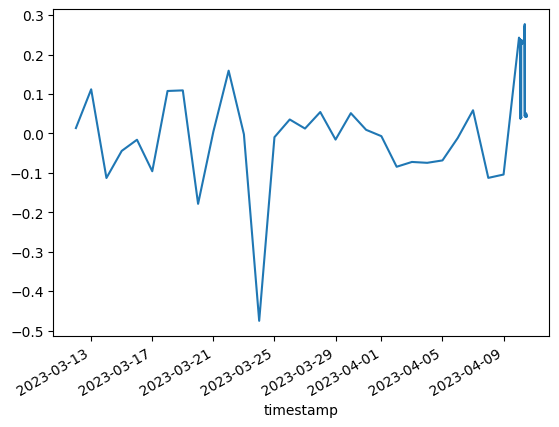

In [20]:
spread.set_index("timestamp").mid_price.plot()

<AxesSubplot:xlabel='timestamp'>

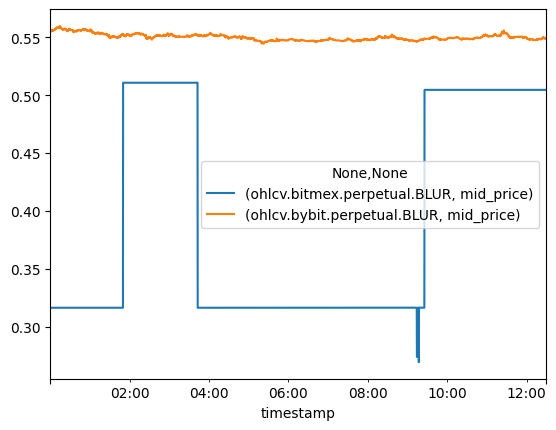

In [95]:
spread = pickle.loads(spreads.iloc[0].spread)
pd.DataFrame(spread.set_index("timestamp").underlying_col("mid_price")).iloc[30:].plot()

<AxesSubplot:xlabel='timestamp'>

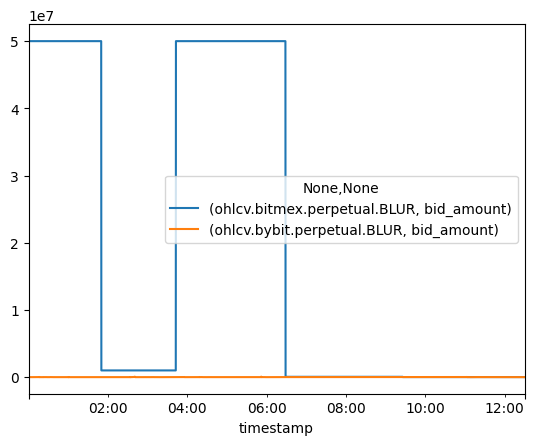

In [103]:
pd.DataFrame(spread.set_index("timestamp").underlying_col("bid_amount")).iloc[30:].plot()

In [106]:
spread.iloc[30:]

,timestamp,bid_price,ask_price,bid_amount,ask_amount,mid_price
30,2023-04-10 00:00:05,0.555243,-0.077137,2.500096e+07,200647.271429,0.239053
31,2023-04-10 00:00:10,0.555327,-0.077100,2.500087e+07,200617.560606,0.239114
32,2023-04-10 00:00:15,0.555400,-0.077100,2.500056e+07,200062.500000,0.239150
33,2023-04-10 00:00:20,0.555400,-0.077100,2.500074e+07,200062.500000,0.239150
34,2023-04-10 00:00:25,0.555400,-0.077100,2.500085e+07,200062.500000,0.239150
...,...,...,...,...,...,...
9024,2023-04-10 12:29:35,0.172550,-0.083844,5.688719e+03,204258.656250,0.044353
9025,2023-04-10 12:29:40,0.172641,-0.083671,6.015735e+03,202576.882353,0.044485
9026,2023-04-10 12:29:45,0.172700,-0.083700,5.693765e+03,203224.941176,0.044500
9027,2023-04-10 12:29:50,0.172700,-0.083700,5.693765e+03,203224.941176,0.044500


In [101]:
quotes.loc["bitmex"]

quotes
inst_type symbol                                                   
perpetual BLUR    b'\x80\x04\x95\x0b\x01\x00\x00\x00\x00\x00\x00...
          DOGE    b'\x80\x04\x95\x0b\x01\x00\x00\x00\x00\x00\x00...
          SOL     b'\x80\x04\x95\x0b\x01\x00\x00\x00\x00\x00\x00...
          LUNA    b'\x80\x04\x95\x0b\x01\x00\x00\x00\x00\x00\x00...
          DOT     b'\x80\x04\x95\x0b\x01\x00\x00\x00\x00\x00\x00...
          XRP     b'\x80\x04\x95\x0b\x01\x00\x00\x00\x00\x00\x00...
          MATIC   b'\x80\x04\x95\x0b\x01\x00\x00\x00\x00\x00\x00...
          LTC     b'\x80\x04\x95\x0b\x01\x00\x00\x00\x00\x00\x00...
          GMX     b'\x80\x04\x95\x0b\x01\x00\x00\x00\x00\x00\x00...
          AVAX    b'\x80\x04\x95\x0b\x01\x00\x00\x00\x00\x00\x00...
          BCH     b'\x80\x04\x95\x0b\x01\x00\x00\x00\x00\x00\x00...
          BTC     b'\x80\x04\x95\x0b\x01\x00\x00\x00\x00\x00\x00...
          GMT     b'\x80\x04\x95\x0b\x01\x00\x00\x00\x00\x00\x00...
          BNB     b'\x80\x04\x95\x0b\x01\x00\x00\x00\x00\x00\x00...
          ADA     b'\x80\x04\x95\x0b\x01\x00\x00\x00\x00\x00\x00...
          APE     b'\x80\x04\x95\x0b\x01\x00\x00\x00\x00\x00\x00...
          ETH     b'\x80\x04\x95\x0b\x01\x00\x00\x00\x00\x00\x00...

In [99]:
spread.ohlcv_list[0].exchange_name

'bitmex'

<AxesSubplot:>

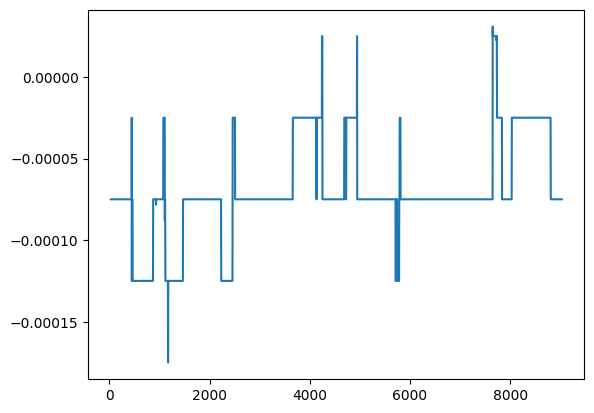

In [52]:
spread.mid_price.iloc[30:].plot()

In [62]:
spread.set_index("timestamp").mid_price.head(20)

timestamp
2023-03-12   -0.00005
2023-03-13    0.00000
2023-03-14    0.00005
2023-03-15    0.00005
2023-03-16   -0.00005
2023-03-17   -0.00020
2023-03-18   -0.00005
2023-03-19   -0.00005
2023-03-20   -0.00005
2023-03-21   -0.00010
2023-03-22   -0.00005
2023-03-23   -0.00005
2023-03-24   -0.00010
2023-03-25   -0.00010
2023-03-26   -0.00005
2023-03-27    0.00005
2023-03-28    0.00000
2023-03-29   -0.00010
2023-03-30   -0.00020
2023-03-31   -0.00020
Name: mid_price, dtype: float64

<AxesSubplot:>

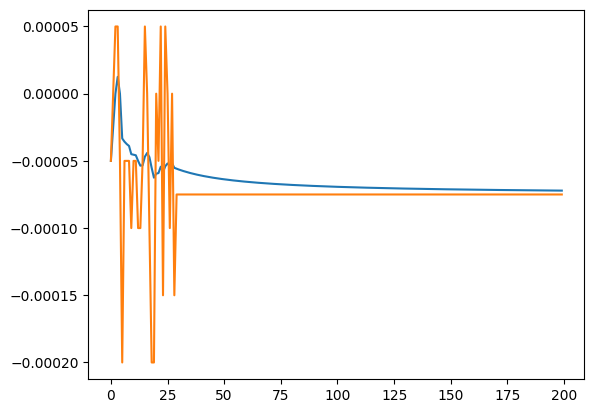

In [89]:
spread.set_index("timestamp").mid_price.rolling("30D").mean().reset_index(drop=True).head(200).plot()
spread.set_index("timestamp").mid_price.head(200).reset_index(drop=True).plot()

<AxesSubplot:>

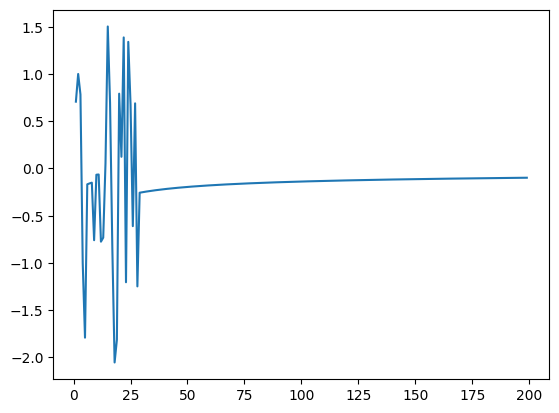

In [94]:
spread.zscore("mid_price", period="30D").reset_index(drop=True).head(200).plot()

In [56]:
spread.zscore("mid_price", period=pd.Timedelta("30D"))

timestamp
2023-03-12 00:00:00         NaN
2023-03-13 00:00:00    0.707107
2023-03-14 00:00:00    1.000000
2023-03-15 00:00:00    0.783349
2023-03-16 00:00:00   -1.000000
                         ...   
2023-04-10 12:29:35   -0.179707
2023-04-10 12:29:40   -0.179697
2023-04-10 12:29:45   -0.179687
2023-04-10 12:29:50   -0.179676
2023-04-10 12:29:55   -0.179666
Name: zscore, Length: 9029, dtype: float64

<AxesSubplot:xlabel='timestamp'>

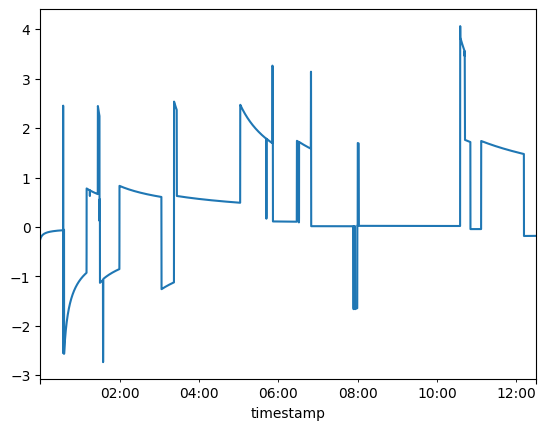

In [51]:
spread.zscore(column="mid_price").iloc[30:].plot()